#### 1. 모형최적화 
- 가장 중요한 하이퍼파라미터 튜닝

#### 2. 비대칭 데이터 문제
- 어떤 Feature는 데이터가 많고, 어떤 Feature는 데이터가 적고 이런 경우가 있음.
- 예컨데, 희귀병 검진에서 정상인의 데이터는 엄청 많고, 희귀병 데이터는 적음. 

#### 3. 특징 선택 
- 데이터가 너무 큰 경우. 
- 데이터가 크다는 것은 두가지가 있음.
    - 데이터의 종류가 너무 많은 경우(열). 
    - 데이터의 갯수가 너무 많은 경우(행). 

#### 4. 대규모 데이터 학습

# 모형 최적화

머신 러닝 모형이 완성된 후에는 최적화 과정을 통해 예측 성능을 향상시킨다.

## Scikit-Learn 의 모형 하이퍼 파라미터 튜닝 도구

3가지 툴을 사용할 수 있다. 

Scikit-Learn에서는 다음과 같은 모형 최적화 도구를 지원한다.

* [`validation_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
  * 단일 하이퍼 파라미터 최적화
  * 튜닝할 하이퍼파라미터가 딱 1개 밖에 없을 때. 
* [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  * 그리드를 사용한 복수 하이퍼 파라미터 최적화
  * 2개 이상의 하이퍼파라미터를 튜닝해야 하는 경우. 
* [`ParameterGrid`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html)  
 * 복수 파라미터 최적화용 그리드
 * GridSearchCV는 자기가 알아서 여러개 테스트 해보는데, 그것을 수동으로 하고 싶은 경우 사용한다. 


## `validation_curve` 

`validation_curve` 함수는 최적화할 파라미터 이름과 범위, 그리고 성능 기준을 `param_name`, `param_range`, `scoring` 인수로 받아 파라미터 범위의 모든 경우에 대해 성능 기준을 계산한다.

- 최적화할 파라미터 이름
- 파라미터가 가질 수 있는 범위
- 각 파라미터마다 점수 매길 스코어. 

In [11]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 10)

In [2]:
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

gamma하나만, 튜닝 하는 경우. 지금 SVC긴 한데 커널이 아무것도 안써있다? 그럼 RDF(가우시안 커널 사용)<br>
거기서, 감마에 따라 원이 둥그스름할지, 아니면 데이터 모양에 맞게 뾰족뾰족 하게 할지를 테스트 해본다.<br>

param_range쓸때, 대부분이 경우는 `logspace` [logspace reference](https://spacecollection.co.kr/9) 를 많이 사용한다.<br>
왜냐면, 아주 큰 범위를 훑어야 하기 때문에, 100 200, 300 이렇게 훑지 않고, <br>
100, 10, 1, 0.1, 0.001 이런식으로 스캐닝 한다. <br>


`logspace(-6, -1, 10)`이라고 쓰면, $10^{-6}$부터, $10^{-1}$ 사이를 10등분 하라는 것. 

CV=10. 각 종류의 포인트마다 파라미터를 10번씩 테스트 한다. <br>
그럼, 지금 10개의 포인트를 CV=10으로 테스트 하니깐, 총 모델링 100번 하는 것. <br>
n_jobs는 추후에. 

In [3]:
%%time
train_scores, test_scores = \
    validation_curve(SVC(), X, y,
                     param_name="gamma", param_range=param_range,
                     cv=10, scoring="accuracy", n_jobs=1)

CPU times: user 49.4 s, sys: 818 ms, total: 50.3 s
Wall time: 51.8 s


In [6]:
train_scores.shape, test_scores.shape

((10, 10), (10, 10))

`train_scores`와 `test_scores`에는 각각 100개의 값이 담기겠지. 

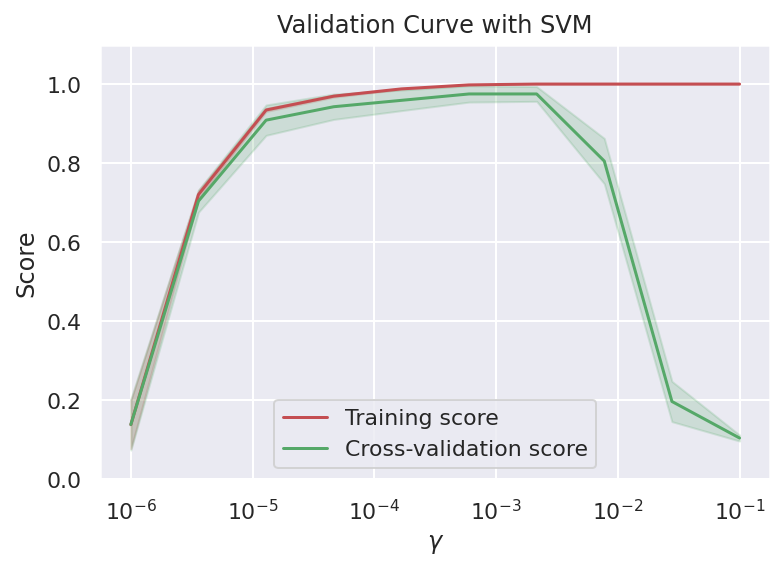

In [7]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

지금 shadow는 각 점에서 표준편차 나타낸 것. 

감마가 커질수록, 데이터에 맞게 오돌도돌하게 오버피팅이 된다고 했다. <br>
위에 보면, 빨간색이 학습성능인데 감마가 커질수록 점점 1로 다가간다. <br>
근데, 테스트 퍼포먼스 감마가 커지면서 같이 커지다가 뚝 떨어진다. 여기서 오버피팅이 발생을 한 것. <br>

**그럼, 이제 뭘 해야돼? $10^{-3}$ 부근을 더 작게 쪼개서 또 테스트 해야지**

즉, 하이퍼파라미터 튜닝에서 중요한 것은 처음에는 큰 스케일로 넓은 범위를 훑고 그 다음에, 괜찮은 지역에서 작은 범위를 훑어가고 그렇게 해가는 것. 

근데, 파라미터 갯수가 엄청 많지. QDA같은 경우는 1개 밖에 없지만, 모델이 복잡할수록 인수가 엄청 많음. <br>
다 하이퍼파라미터 튜닝을 해야한다. <br>
각 조합의 포인트마다 다 해봐야지. 해야될게 엄청 많아진다. 

## `GridSearchCV`

`GridSearchCV`  클래스는 `validation_curve` 함수와 달리 모형 래퍼(Wrapper) 성격의 클래스이다.  클래스 객체에 `fit` 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다. 생성된 복수개와 내부 모형과 실행 결과는 다음 속성에 저장된다.

* `grid_scores_ `
 * param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
  * parameters: 사용된 파라미터
  * mean_validation_score: 교차 검증(cross-validation) 결과의 평균값
  * cv_validation_scores: 모든 교차 검증(cross-validation) 결과
* `best_score_` 
 * 최고 점수 
* `best_params_`
 * 최고 점수를 낸 파라미터
* `best_estimator_`
 * 최고 점수를 낸 파라미터를 가진 모형

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Scaler뒤에, SVC분류기
# SCV에서 Kernel, C 등을 조절할 수 있지. 
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

# 그리드를 내가 직접 만들어 간다. 
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# 그리드 조합 만든거 보면, 
# 1. param_range의 8포인트 + linear로 조사해라. 8포인트
# 2. param_range 8개, 감마도 8개, 그리고 그때는 커널을 rbf로 조사해라. 총 64개 조사
# 총 72포인트 조사하는 것. 
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

# 그런데, CV=10으로 해놨으니깐, 그것을 각 포인트에서 10번씩. 그러면 포인트가 총 72개니깐 총 720번 모델링을 하는 것. 
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10, n_jobs=1)
%time gs = gs.fit(X, y)

CPU times: user 4min 5s, sys: 3.85 s, total: 4min 9s
Wall time: 4min 17s


In [9]:
gs.cv_results_["params"]

[{'clf__C': 0.0001, 'clf__kernel': 'linear'},
 {'clf__C': 0.001, 'clf__kernel': 'linear'},
 {'clf__C': 0.01, 'clf__kernel': 'linear'},
 {'clf__C': 0.1, 'clf__kernel': 'linear'},
 {'clf__C': 1.0, 'clf__kernel': 'linear'},
 {'clf__C': 10.0, 'clf__kernel': 'linear'},
 {'clf__C': 100.0, 'clf__kernel': 'linear'},
 {'clf__C': 1000.0, 'clf__kernel': 'linear'},
 {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 100.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1000.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C

In [10]:
gs.cv_results_["mean_test_score"]

array([0.23120112, 0.91485413, 0.95046245, 0.95547176, 0.95658908,
       0.95658908, 0.95658908, 0.95658908, 0.13089385, 0.13536313,
       0.13927374, 0.12418994, 0.1001676 , 0.13089385, 0.10687151,
       0.1001676 , 0.13089385, 0.13536313, 0.13927374, 0.12418994,
       0.1001676 , 0.13089385, 0.10687151, 0.1001676 , 0.13089385,
       0.13536313, 0.14429857, 0.12418994, 0.1001676 , 0.13089385,
       0.10687151, 0.1001676 , 0.13089385, 0.68335816, 0.90761639,
       0.40958101, 0.1001676 , 0.13089385, 0.10687151, 0.1001676 ,
       0.70449721, 0.93153011, 0.96047796, 0.90317505, 0.12469894,
       0.1001676 , 0.10128492, 0.1001676 , 0.93264742, 0.95547176,
       0.96937927, 0.90540348, 0.13416511, 0.1001676 , 0.10128492,
       0.1001676 , 0.95547796, 0.96047796, 0.96937927, 0.90540348,
       0.13416511, 0.1001676 , 0.10128492, 0.1001676 , 0.95825885,
       0.95935754, 0.96937927, 0.90540348, 0.13416511, 0.1001676 ,
       0.10128492, 0.1001676 ])

In [11]:
print(gs.best_score_)
print(gs.best_params_)

0.969379267535692
{'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


이제 이 근처에서 그리드 더 세분화 시켜서, 더 fine grid를 만들어서 찾아가야돼. 

param_grid에 넣을 수 있는 dict list를 생성해 주는 것. 

## `ParameterGrid`

때로는 scikit-learn 이 제공하는 GridSearchCV 이외의 방법으로 그리드 탐색을 해야하는 경우도 있다. 이 경우 파라미터를 조합하여 탐색 그리드를 생성해 주는 명령어가 `ParameterGrid` 이다. `ParameterGrid` 는 탐색을 위한 iterator 역할을 한다.

In [12]:
from sklearn.model_selection import ParameterGrid

In [13]:
param_grid = {'a': [1, 2], 'b': [True, False]}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [14]:
param_grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
list(ParameterGrid(param_grid))

[{'kernel': 'linear'},
 {'gamma': 1, 'kernel': 'rbf'},
 {'gamma': 10, 'kernel': 'rbf'}]

근데 이걸 좀 빨리 하고싶으면?<br>
지금 6분 씩 걸려. 

예를 들어, 위에서 72개 Grid, K-FOld까지 총 720번 모델링을 해야 하는데, <br>
그게 꼭 순서대로 할 필요는 없다. 각각이 독립적. <br>
병렬적으로 컴퓨터가 능력만 있으면, 720개 동시에 돌려도 된다. <br>
그걸 동시에 돌리게 하는 명령어가 `n_jobs`.<br>
코어의 갯수만큼, 동시에 계산 가능. <br>
내 컴퓨터가 코어가 8이면 8개 까지 동시에 계산 가능하다. <br><br>


만약에 CPU코어가 4개 짜리 컴퓨터에서 8로 실행하면?<br>
코어마다 2개의 프로세스가 가서 순서대로 실행하게 된다. <br>
정확히 순서대로라기 보다는 잠깐 A, 잠깐 B 이런식으로 실행된다. <br>

**코어의 갯수만큼만 늘리는게 의미가 있다.**

## 병렬 처리

`GridSearchCV` 명령에는 `n_jobs` 라는 인수가 있다. 디폴트 값은 1인데 이 값을 증가시키면 내부적으로 멀티 프로세스를 사용하여 그리드서치를 수행한다. 만약 CPU 코어의 수가 충분하다면 `n_jobs`를 늘릴 수록 속도가 증가한다.

사실 `n_jobs`는 모델들에도 인수로 가지고 있는 애들이 있음. <br>
예를 들어, `Decision_Tree`와 `random forest`는 순서가 필요 없잖아. 이런 애들은 `n_jobs` 인수를 가지고 있다. <br>
Decision Tree같은 경우는 node에서 각각 어떤 피쳐가 좋은지 고르고 그 과정이 순서가 필요가 없잖아. <br>
아무거나 먼저 해도 돼. <br>
Random Forest는 디시젼 트리가 여러개가 있는 애라서 순서가 필요가 없다. <br>

In [15]:
param_grid = {"gamma": np.logspace(-6, -1, 10)}
gs1 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=1)
gs2 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=2)

In [16]:
%%time
gs1.fit(X, y)

CPU times: user 14 s, sys: 199 ms, total: 14.1 s
Wall time: 14.6 s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=1,
             param_grid={'gamma': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])},
             scoring='accuracy')

In [17]:
%%time
gs2.fit(X, y)

CPU times: user 213 ms, sys: 67.6 ms, total: 280 ms
Wall time: 8.96 s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=2,
             param_grid={'gamma': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])},
             scoring='accuracy')

실제 하드웨어의 코어 수가 부족하다면 병렬로 실행되지 않으므로 실행시간이 단축되지 않는다.

병렬처리(`parallel`)는 코어의 갯수 만큼만 가능하다. 더 많이 하고 싶으면?<br>
분산처리 `distributed`를 해야 한다. <br>

병렬처리는 한 컴퓨터 안에서 코어 여러개에 프로세스를 나눠서 하는 것. <br>
분산처리는 컴퓨터 여러개를 쓰는 것. 통신을 통해서 일을 서로 나눠주고 받고 하는 것. 
가장 쉬운 것은 다스크. <br>
다만, 컴퓨터 여러개 띄워놓고 + 데이터 똑같이 가져다 놓고 + 환경 똑같이 복사 해놔야함. <br>

이거 할때 위에서, ParamGrid 쓰는 것. 이 조합을 만들어서 적절히 나눠서 컴퓨터마다 일 시키는 것. 

# 비대칭 데이터 문제

데이터 클래스 비율이 너무 차이가 나면(highly-imbalanced data) 단순히 우세한 클래스를 택하는 모형의 정확도가 높아지므로 모형의 성능판별이 어려워진다. 즉, 정확도(accuracy)가 높아도 데이터 갯수가 적은 클래스의 재현율(recall-rate)이 급격히 작아지는 현상이 발생할 수 있다.

이렇게 각 클래스에 속한 데이터의 갯수의 차이에 의해 발생하는 문제들을 비대칭 데이터 문제(imbalanced data problem)이라고 한다.

highly-imbalanced되면, 모형이 이상하게 동작한다. 그냥 대부분을 싹다 다수 클래스라고 해버리고 끝내려고 하는 경향을 보인다. <br>
그렇게 해도 accuracy가 높으니깐. <br>
실제로, 100만명중에 한명 걸리는 병이면, 그냥 모두한테 다 병 안걸렸다고 판단해도 정확도가 99.9999%잖아. <br>

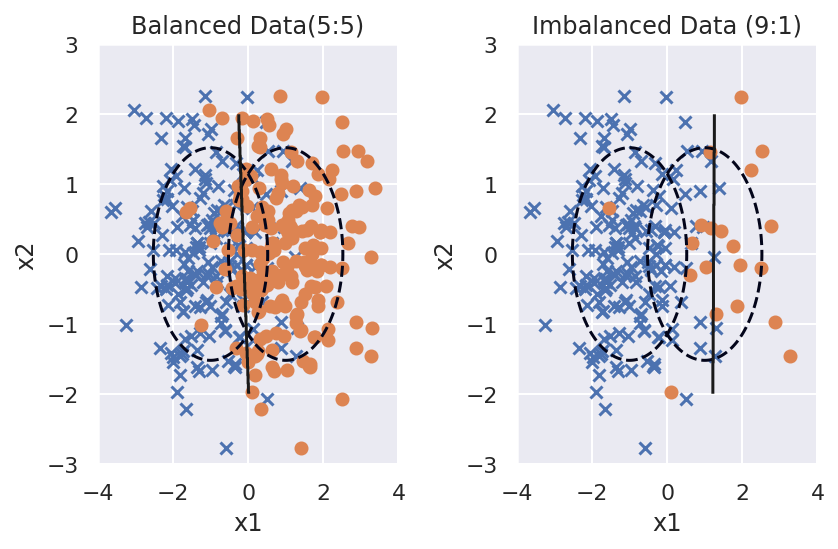

In [104]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC


def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 Class")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 Class")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    
    return model, X, y, y_pred
    
plt.subplot(121)
model1, X1, y1, y_pred1 = classification_result(200, 200, "Balanced Data(5:5)")
plt.subplot(122)
model2, X2, y2, y_pred2 = classification_result(200, 20, "Imbalanced Data (9:1)")
plt.tight_layout()
plt.show()

지금 타원이 likelihood(원래 이 샘플이 튀어 나오는 확률분포). <br>
분류 시키면, 왼쪽은 거의 중앙에 그어졌는데, <br>

다수 소수 있으니깐 다수가 소수를 밀어내는 형태로 판별선이 밀려버린다. <br>
왜 그럴까? 이렇게 긋는게 더 accuracy가 높아. 실제로 중앙으로 땡기면, 훨씬 많은 파란색 x가 misclassified된다. <br>

그래서 어쩔 수 없이 이게 accuracy 입장에서는 왼쪽이 맞아. <br>
우리가 제일 중요하게 생각하는게 accuracy면 어쩔수 없어. 그냥 이대로 놔두면 된다. <br>

그런데, 희귀병 진단을 왜해. 희귀병 걸린 사람을 찾으려고 희귀병 진단을 하는 거잖아. <br>
우리의 목표는 accuracy가 `racall rate`을 높이는게 지금 목표인 경우가 많다. 

실제로 아래 표 보면, accuracy는 imbalanced case가 더 높아. <br>
근데 문제가 뭐냐면, `실제 1 중에 1이라고 예측한 비율`인 recall rate가 너무 낮아. <br>

희귀병 진단은 완전 쓰레기처럼 된거야. 희귀병 실제 걸린 사람 중에, 진단 받은 사람이 40%밖에 안돼. <br>
그 사람들 죽을 수도 있어. 

In [105]:
from sklearn.metrics import classification_report, confusion_matrix

# balanced data
print(classification_report(y1, y_pred1))
# imbalanced data
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       200
         1.0       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



우리가 원하는게 recall rate을 높이는 거면 이거는 문제가 있는 상황

In [14]:
from sklearn.metrics import classification_report


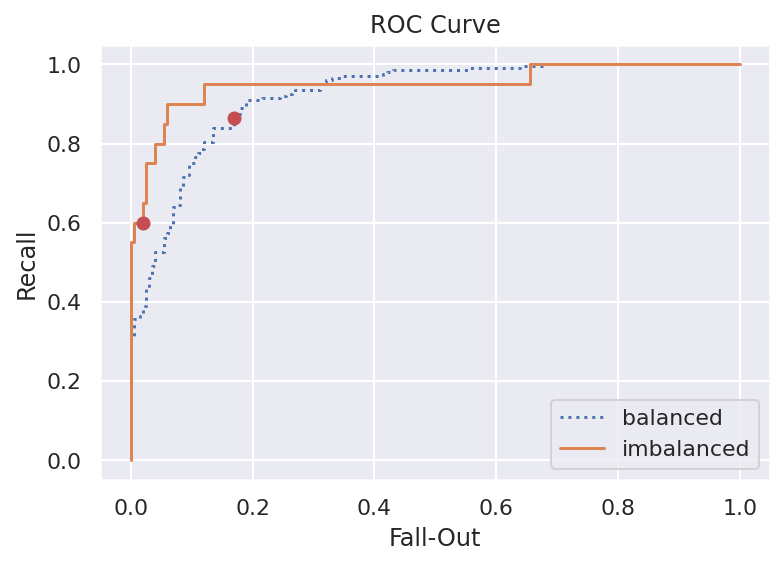

In [106]:
from sklearn.metrics import roc_curve, confusion_matrix

fpr1, tpr1, thresholds1 = roc_curve(y1, model1.decision_function(X1))
fpr2, tpr2, thresholds2 = roc_curve(y2, model2.decision_function(X2))

c1 = confusion_matrix(y1, y_pred1, labels=[1, 0])
c2 = confusion_matrix(y2, y_pred2, labels=[1, 0])
r1 = c1[0, 0] / (c1[0, 0] + c1[0, 1])
r2 = c2[0, 0] / (c2[0, 0] + c2[0, 1])
f1 = c1[1, 0] / (c1[1, 0] + c1[1, 1])
f2 = c2[1, 0] / (c2[1, 0] + c2[1, 1])

plt.plot(fpr1, tpr1, ':', label="balanced")
plt.plot(fpr2, tpr2, '-', label="imbalanced")
plt.plot([f1], [r1], 'ro')
plt.plot([f2], [r2], 'ro')
plt.legend()
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.show()

얼핏 보면 imbalanced가 성능이 좋아보이는데, 문제는 recall rate. <br>

두 가지 approach가 나온다. <br>
1. threshhold를 낮춘다. 그러면, 위에서 roc커브를 타고 이동하면서 recall rate을 높일 수 있겠지. 이게 바로 위 SVM 예시 오른쪽 모델에서 선을 강제로 왼쪽으로 밀어 버리는 것. 

2. 데이터를 강제로 늘리거나 줄이는 방식. 소수 데이터가 다수 데이터의 갯수의 비율이 너무 큰게 문제잖아. 
    - 적은 데이터를 강제로 늘리던가
    - 많은 데이터를 강제로 줄이던가
    - 아니면 위 두가지 동시에 하던가

## 해결 방법

비대칭 데이터는 다수 클래스 데이터에서 일부만 사용하는 **언더 샘플링**이나 소수 클래스 데이터를 증가시키는 **오버 샘플링**을 사용하여 데이터 비율을 맞추면 정밀도(precision)가 향상된다.

* 오버샘플링(Over-Sampling) - 소수 강제로 불리는 것. 
* 언더샘플링(Under-Sampling) - 많은애를 줄이는 것. 
* 복합샘플링(Combining Over-and Under-Sampling) - 둘다

## imbalanced-learn 패키지

In [4]:
!pip3 install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages (0.24.2)


In [6]:
!pip3 install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages (0.8.0)


imbalanced data 문제를 해결하기 위한 다양한 샘플링 방법을 구현한 파이썬 패키지


```
pip install -U imbalanced-learn
```

## 언더 샘플링

Under Sampling : 다수 데이터를 날려버려서 비율을 맞추는 것. <br>

날리는 방식들도 아래와 같은 방식들이 있는 것. 

* `RandomUnderSampler`: random under-sampling method
* `TomekLinks`: Tomek’s link method
* `CondensedNearestNeighbour`: condensed nearest neighbour method
* `OneSidedSelection`: under-sampling based on one-sided selection method
* `EditedNearestNeighbours`: edited nearest neighbour method
* `NeighbourhoodCleaningRule`: neighbourhood cleaning rule

In [10]:
from imblearn.under_sampling import *

n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])

x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)

def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 Class")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 Class")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model

## Ramdom Under-Sampler

* 무작위로 데이터를 없애는 단순 샘플링

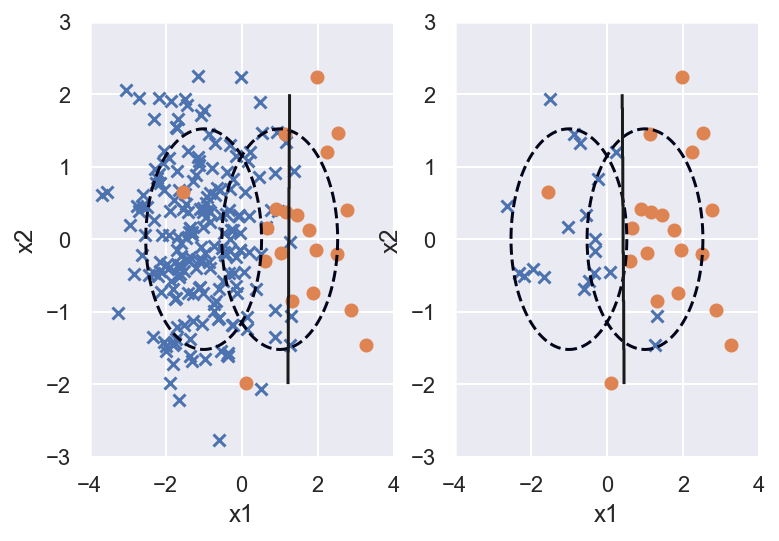

In [12]:
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [15]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220



recall rate이 90%까지 올라왔음. 원래 60%였음. 

## Tomek’s link method

서로 다른 클래스에 속하면서 가까이 붙어있는 한 쌍을 `Tomek’s link`라고 부른다. <br>
1. 나한테 가장 가까이있는 애가 잡아.
2. 근데 걔가 상대편 클래스야? 
3. 그러면 이 쌍을 합쳐서 `Tomek's link`라고 부른다. 

그러면 얘네들은, 경계선 혹은 상대편 내부 진영으로 침투해 있는 애들 사이에서 많이 생기겠지. <br>
`Tomek's link`만 싹다 없애면 경계선에 있던 애들과 상대편 진영에 침투해 있던 애들이 사라지게 된다. <br>
사실 경계선에 있는 애들 없어지는 거는 우리가 당면한 문제에 영향력은 크게 없음. <br>
경계선 데이터 없어진다고 선이 이동하는 것은 아니기 때문. <br>

그런데, 내부에 침투해 있던 애들이 없어지는 것은 어느정도 선 이동시키는 역할을 한다. 

토멕링크(Tomek’s link)란 서로 다른 클래스에 속하는 한 쌍의 데이터 $(x_{+}, x_{-})$로 서로에게 더 가까운 다른 데이터가 존재하지 않는 것이다. 즉 클래스가 다른 두 데이터가 아주 가까이 붙어있으면 토멕링크가 된다. 토멕링크 방법은 이러한 토멕링크를 찾은 다음 그 중에서 다수 클래스에 속하는 데이터를 제외하는  방법으로 경계선을 다수 클래스쪽으로 밀어붙이는 효과가 있다.

![1_142.png](./materials/1_142.png)

아래 직접 그림 그린거 보면, 주황색에 침투해있던 파란 x들이 많이 사라졌음. <br>

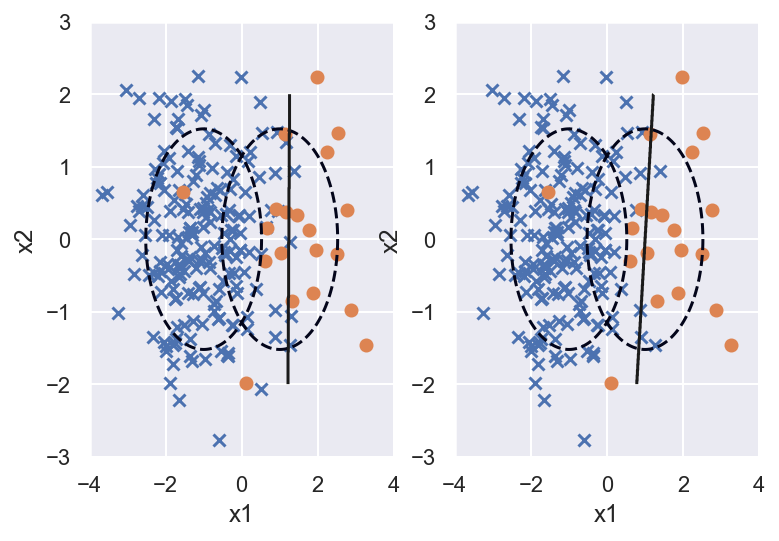

In [19]:
X_samp, y_samp = TomekLinks().fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [20]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



얘도 recall 늘어나긴 했음. 

1-NN. 가장 가까운 이웃을 기준으로 데이터 남길지 말지 선택하는 것. <br>
남길 데이터의 집합을 `S`라고 한다. 그리고, 다수 클래스에서 랜덤하게 아무거나 하나 고른다. <br>
그 골라진 데이터 입장에서 제일 가까운 데이터를 찾아본다. 그게 똑같이 다수클래스면 다수클래스 모임 안에 있다는 뜻. <br>
걔는 안고른다. <br>

그럼 얘는 Tomek's Link와 정반대의 결과가 나오게 된다. <br>
**경계선 근처?만 남게 된다.** 경계선이 중요하니깐, 경계선 근처를 남겨놓는 방식. 

![1_143.jpeg](./materials/1_143.jpeg)

사실 서포트벡터머신도 전방애 있는 애들만 사용하는 거였음. 

## Condensed Nearest Neighbour

CNN(Condensed Nearest Neighbour) 방법은 1-NN 모형으로 분류되지 않는 데이터만 남기는 방법이다. 선텍된 데이터 집합을 $S$라고 하자.

1. 소수 클래스 데이터를 모두 $S$에 포함시킨다.
2. 다수 데이터 중에서 하나를 골라서 가장 가까운 데이터가 다수 클래스이면 포함시키지 않고 아니면 $S$에 포함시킨다.
3. 더이상 선택되는 데이터가 없을 때까지 2를 반복한다.

이 방법을 사용하면 기존에 선택된 데이터와 가까이 있으면서 같은 클래스인 데이터는 선택되지 않기 때문에 다수 데이터의 경우 선택되는 비율이 적어진다.

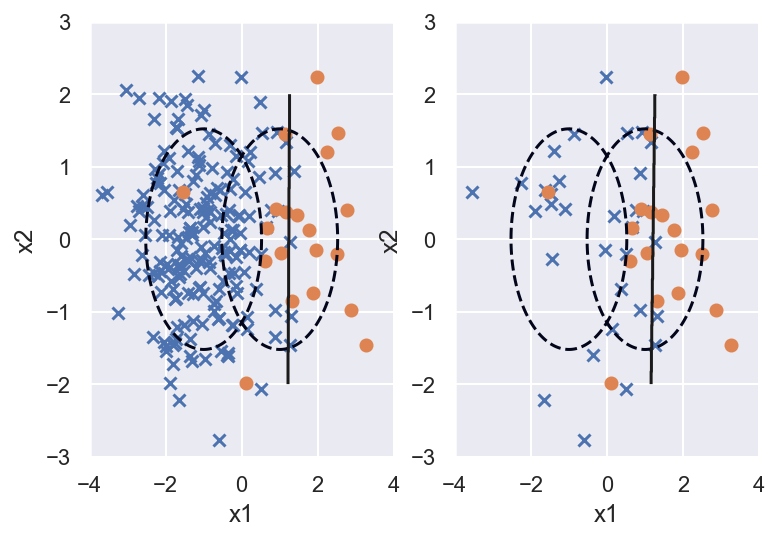

In [21]:
X_samp, y_samp = CondensedNearestNeighbour(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [22]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



이거는 `Tomek's link`방식과 `CNN` 방식을 동시에 사용하는 것. 

## One Sided Selection

One Sided Selection은 토맥링크 방법과 Condensed Nearest Neighbour 방법을 섞은 것이다. 토맥링크 중 다수 클래스를 제외하고 나머지 데이터 중에서도 서로 붙어있는 다수 클래스 데이터는 1-NN 방법으로 제외한다.

Tomek's Link를 쓰면, 경계선에 있거나 반대 진영에 침투한 애들이 사라진다. 그거로 먼저 제거시킨 후에 <br>
CNN방법을 적용해서, 남은 애들 중에서 경계선을 남긴다. 

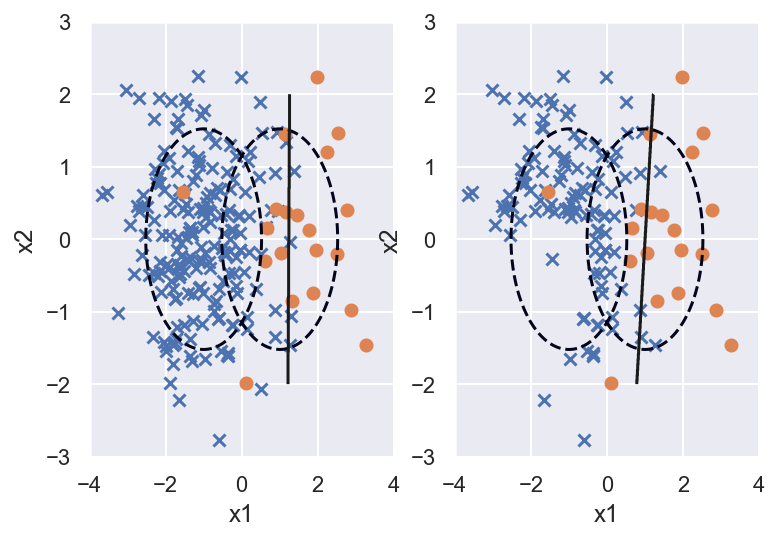

In [23]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [24]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



## Edited Nearest Neighbours

다수에서 하나 뽑아서, 주변에 N개를 봐. 그 다음에 N개 중에 소수가 더 많으면 없앤다. <br>
침투해있는 안쪽에 있는 애들이 사라진다. 

ENN(Edited Nearest Neighbours) 방법은 다수 클래스 데이터 중 가장 가까운 k(`n_neighbors`)개의 데이터가 모두(`kind_sel="all"`) 또는 다수(`kind_sel="mode"`) 다수 클래스가 아니면 삭제하는 방법이다. **소수 클래스 주변의 다수 클래스 데이터는 사라진다.**

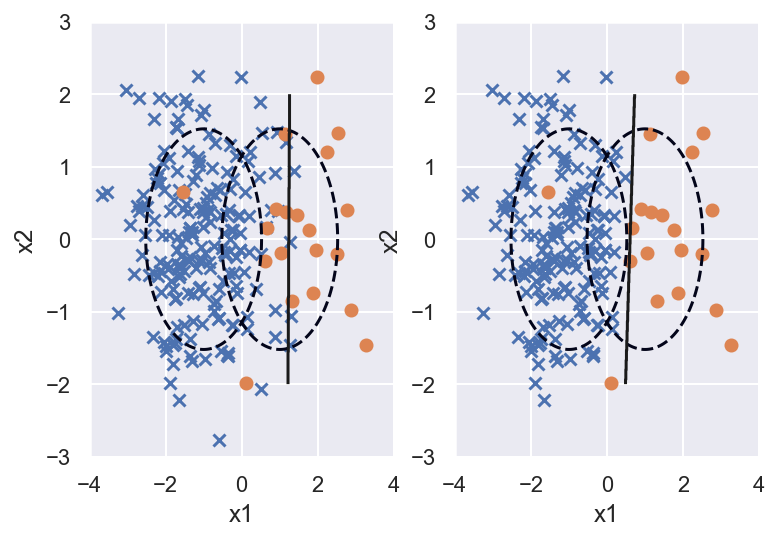

In [30]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

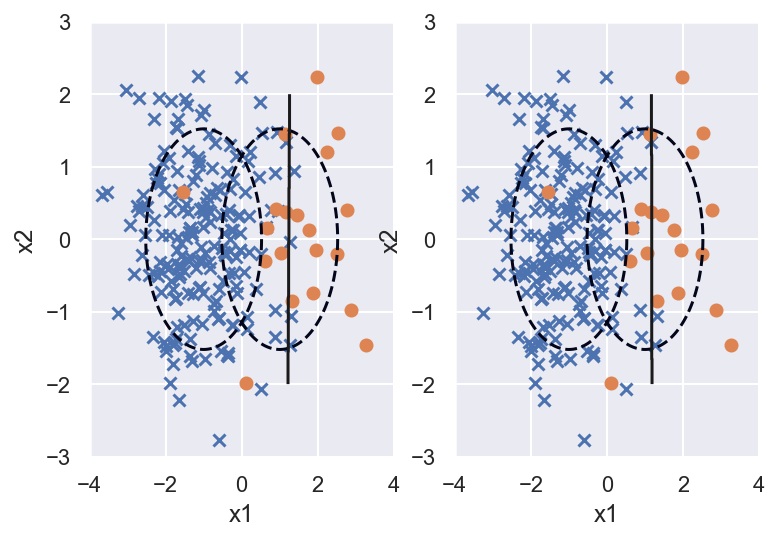

In [28]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [27]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       200
         1.0       0.58      0.90      0.71        20

    accuracy                           0.93       220
   macro avg       0.79      0.92      0.83       220
weighted avg       0.95      0.93      0.94       220



## Neighbourhood Cleaning Rule

CNN은 경계선 아닌애들 주로 없애고, <br>
ENN은 반대편에 침투한 애들 주로 없앴음. 

Neighbourhood Cleaning Rule 방법은 CNN(Condensed Nearest Neighbour) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

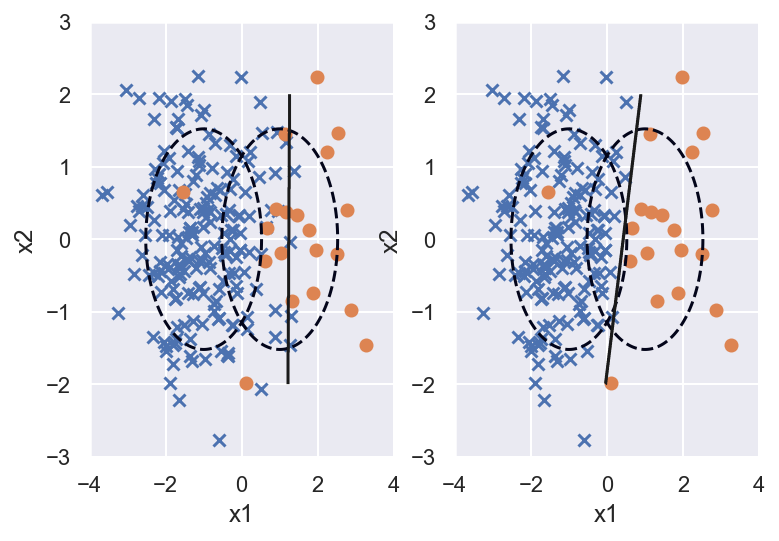

In [32]:
X_samp, y_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [34]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       200
         1.0       0.56      0.95      0.70        20

    accuracy                           0.93       220
   macro avg       0.78      0.94      0.83       220
weighted avg       0.96      0.93      0.94       220



## 오버 샘플링

이 방법은 소수인 데이터를 강제로 늘려버리는 방식

* `RandomOverSampler`: random sampler
* `ADASYN`: Adaptive Synthetic Sampling Approach for Imbalanced Learning
* `SMOTE`: Synthetic Minority Over-sampling Technique

In [35]:
from imblearn.over_sampling import *

## RandomOverSampler

강제로 copy and paste하는 것. 똑같이 복사. 그냥 weight를 늘린것. 어쨋든 아래 그림 보면 쏠리긴 하네. 

Random Over Sampling은 소수 클래스의 데이터를 반복해서 넣는 것(replacement)이다. 가중치를 증가시키는 것과 비슷하다.

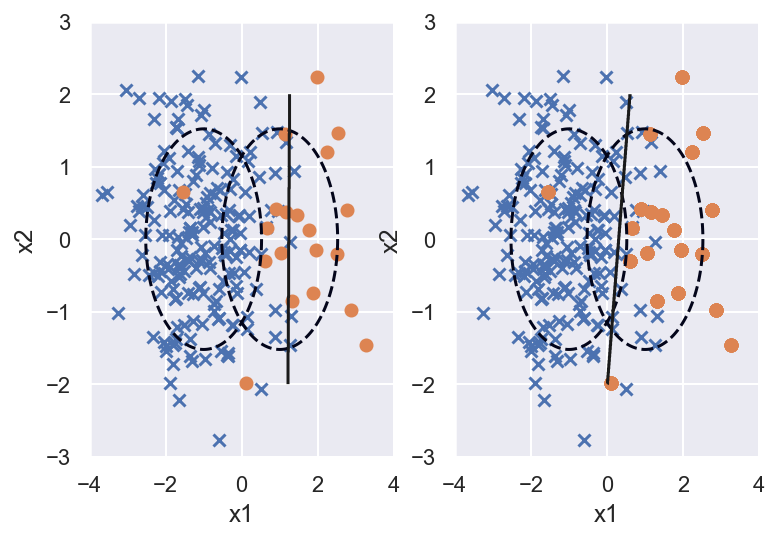

In [36]:
X_samp, y_samp = RandomOverSampler(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

그림 양쪽 똑같아. 왜? 그냥 `copy and paste` 한거라서, 주황색에 몇개 겹쳐져 있는 거야 지금. 

In [37]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.51      0.95      0.67        20

    accuracy                           0.91       220
   macro avg       0.75      0.93      0.81       220
weighted avg       0.95      0.91      0.92       220



## ADASYN

소수 클래스를 하나 뽑고, 걔 기준으로 걔랑 가장 가까운 소수 클래스 하나 더 뽑는다. <br>
그리고, 걔네 둘이 부모가 되서, 그 중간 사이에 가상으로 하나 더 데이터를 만든다. <br>
그 중간이라는 것도 가중치에 따라 다르잖아. 그 가중치 마저도 랜덤하게 주는 것. <br>

되도록이면 가까이 있는 위주로 선택해서 만든다. 

마이너인 데이털ㄹ 싹다 돌면서 데이터를 하나 고르고, 주변 neighborhood를 찾는다. 보통은 KNN으로 찾는다. <br>
예를 들어 KNN에서 K=3이면, 마이너중에 하나 고르고 가장 가까운 3개(SMMOTHE는 가장 가까운 동료 마이너 3개를 찾지만 여기서는 그냥 가장 주변 3개를 찾는다) 찾는다.<br>
근데 그 3개가 확률적으로 과반이 마이너 친구면 데이터 안 만들고 넘어간다. <br>
주변에 우리 친구 아닌 다수가 많으면 그때 upsample을 한다. 
그 다음 마이너 골라서 똑같이 해서 또 데이터 만든다. 이렇게 반복하는 과정.  <br>
즉, 모든 데이터를 돌면서 업샘플을 하는 과정. <br>

ADASYN에서는 지들끼리만 있는 곳에서는 업샘플이 거의 안되있고, 적진에 침투되있는 애들에서 업샘플이 많이 된다. <br>
SMOOTEN같은 경우는 마이너가 퍼지있는 곳에 전체적으로 업샘플이 된다. 

ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

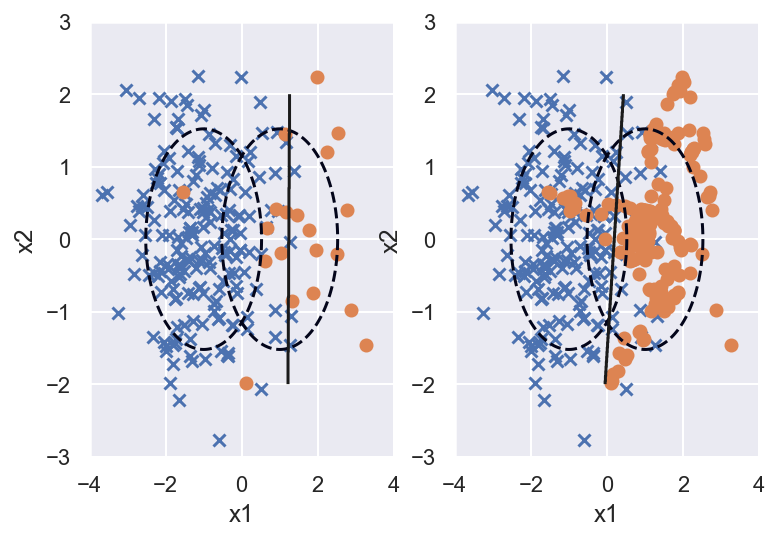

In [38]:
X_samp, y_samp = ADASYN(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [40]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       200
         1.0       0.47      0.95      0.63        20

    accuracy                           0.90       220
   macro avg       0.73      0.92      0.79       220
weighted avg       0.95      0.90      0.91       220



## SMOTE

ADASYN이랑 똑같은데, 지금까지는 소수데이터 사이에 있는 애들 싹다 소수로 다시 만들었음. <br>
그 중간이 다수 데이터 쪽에 가까이 있으면 다수데이터도 좀 만들고 그런식으로 섞는 방식. 

SMOTE(Synthetic Minority Over-sampling Technique) 방법도 ADASYN 방법처럼 데이터를 생성하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

![1_144.png](./materials/1_144.png)

마이너인 데이털ㄹ 싹다 돌면서 데이터를 하나 고르고, 주변 neighborhood를 찾는다. 보통은 KNN으로 찾는다. <br>
예를 들어 KNN에서 K=3이면, 마이너중에 하나 고르고 가장 가까운 동료 마이너를 3개 찾는다. 그 3개를 조합해서 새로운 데이터를 하나 만든다. <br>
그 다음 마이너 골라서 똑같이 해서 또 데이터 만든다. 이렇게 반복하는 과정.  <br>
즉, 모든 데이터를 돌면서 업샘플을 하는 과정. 

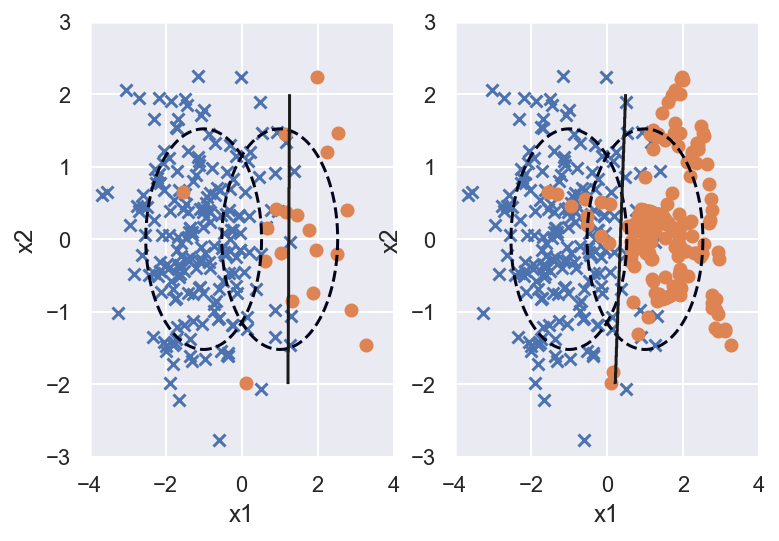

In [41]:
X_samp, y_samp = SMOTE(random_state=4).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [42]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.50      0.90      0.64        20

    accuracy                           0.91       220
   macro avg       0.74      0.91      0.80       220
weighted avg       0.94      0.91      0.92       220



## 복합 샘플링

* `SMOTEENN`: SMOTE + ENN
* `SMOTETomek`: SMOTE + Tomek

In [43]:
from imblearn.combine import *

## SMOTE+ENN

SMOTE+ENN 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

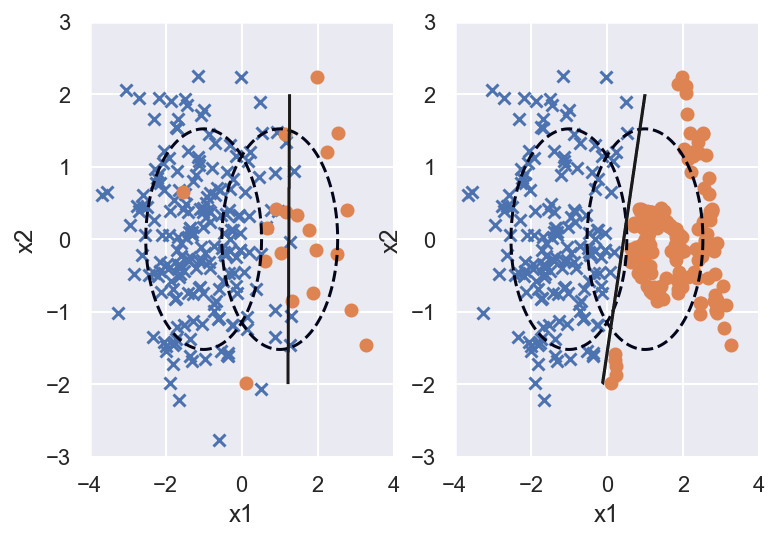

In [45]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

## SMOTE+Tomek

SMOTE+Tomek 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 토멕링크 방법을 섞은 것이다.

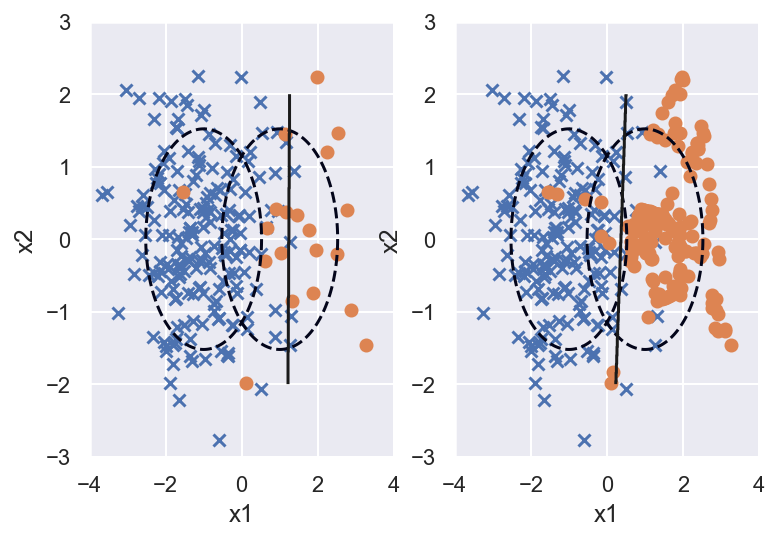

In [46]:
X_samp, y_samp = SMOTETomek(random_state=4).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [47]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220



# 특징 선택

데이터의 종류가 너무 많으면, 일부만 골라 써야지. 특징을 선택할 수 밖에 없는 경우가 발생한다. <br>
모델마다 다르긴 한데, 나이브베이즈 같은 애들은 feature가 굉장히 많아도 돌아감. 그런데, SVM이런 애들은 종류가 많으면 완전 쥐약이다. <br>
SVM은 feature가 늘어나면 그 제곱에 비례해서 계산량이 늘어난다. <br>
그 외에도, Random Forest, Decision Tree, Boosting 이런애들도 다 선형적으로 시간이 늘어나게 된다. <br>

아예 돌리지 못하는 경우가 생긴다. <br>
중요한 피쳐를 선택해야 한다. <br>
어떻게 선택할 것인가?<br>

실무에서는 대규모의 데이터를 기반으로 분류예측 모형을 만들어야 하는 경우가 많다. 대규모의 데이터라고 하면 표본의 갯수가 많거나 아니면 독립변수 즉, 특징데이터의 종류가 많거나 혹은 이 두가지 모두인 경우가 있다. 여기에서는 특징데이터의 종류가 많은 경우에 가장 중요하다고 생각되는 특징데이터만 선택하여 특징데이터의 종류를 줄이기 위한 방법에 대해 알아본다.

In [18]:
%%time
from sklearn.datasets import fetch_rcv1
rcv_train = fetch_rcv1(subset="train")
rcv_test = fetch_rcv1(subset="test")
X_train = rcv_train.data
y_train = rcv_train.target
X_test = rcv_test.data
y_test = rcv_test.target

# Ont-Hot-Encoding된 라벨을 정수형으로 복원
classes = np.arange(rcv_train.target.shape[1])
y_train = y_train.dot(classes)
y_test = y_test.dot(classes)

print(X_train.shape)

(23149, 47236)
CPU times: user 9.4 s, sys: 1.88 s, total: 11.3 s
Wall time: 12 s


*정해진 것은 없다. 그냥 실무에서 많이 쓰는 방법을 소개한다.*

## 분산에 의한 선택

원래 예측 모형에서, 중요한 feature란? 종속변수와의 상관관계가 크고 예측에 도움이 되는 데이터. <br>
그런데, **애초에 도움이 되고 자시고, x가 막 변하는데 y가 안변해?**<br>
그럼 상관관계가 있는게 맞냐?<br>

x가 달라지면, y도 뭔가 달라지긴 해야 그 다음에 상관관계가 있고 말고 하는거지. 아예 안변하면 상관관계 따질것도 없지. <br>
즉, 안 움직이는 애 먼저 빼면 된다. **분산** <br>
즉, STD가 너무 적은 애들은 먼저 빼는 것. 

원래 예측모형에서 중요한 특징데이터란 종속데이터와의 상관관계가 크고 예측에 도움이 되는 데이터를 말한다. 하지만 상관관계 계산에 앞서 **특징데이터의 값 자체가 표본에 따라 그다지 변하지 않는다면 종속데이터 예측에도 도움이 되지 않을 가능성이 높다.** 따라서 표본 변화에 따른 데이터 값의 변화 즉, 분산이 기준치보다 낮은 특징 데이터는 사용하지 않는 방법이 분산에 의한 선택 방법이다.
예를 들어 종속데이터와 특징데이터가 모두 0 또는 1 두가지 값만 가지는데 종속데이터는 0과 1이 균형을 이루는데 반해 특징데이터가 대부분(예를 들어 90%)의 값이 0이라면 이 특징데이터는 분류에 도움이 되지 않을 가능성이 높다.

하지만 **분산에 의한 선택은 반드시 상관관계와 일치한다는 보장이 없기 때문에 신중하게 사용해야 한다.**<br>
근데, 경험적으로는 꽤 괜찮다. 계산량도 적어서 테스트도 쉽다.  

심지어 따로 명령어가 있네. 

In [20]:
X_train.shape

(23149, 47236)

In [19]:
# 애초에 너무 분산 작은 애들은 빼고 시작한다. 
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(1e-5)
X_train_sel = selector.fit_transform(X_train)
X_test_sel = selector.transform(X_test)
X_train_sel.shape

(23149, 14330)

In [21]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [22]:
%%time
model = BernoulliNB()
model.fit(X_train, y_train)
print("train accuracy:{:5.3f}".format(accuracy_score(y_train, model.predict(X_train))))
print("test accuracy :{:5.3f}".format(accuracy_score(y_test, model.predict(X_test))))

train accuracy:0.381
test accuracy :0.324
CPU times: user 30.6 s, sys: 6.82 s, total: 37.4 s
Wall time: 40.4 s


In [23]:
%%time
model = BernoulliNB()
model.fit(X_train_sel, y_train)
print("train accuracy:{:5.3f}".format(accuracy_score(y_train, model.predict(X_train_sel))))
print("test accuracy :{:5.3f}".format(accuracy_score(y_test, model.predict(X_test_sel))))

train accuracy:0.529
test accuracy :0.441
CPU times: user 23 s, sys: 3.17 s, total: 26.2 s
Wall time: 27.1 s


feature 3/4가 날라갔는데, 테스트 퍼포먼스가 오히려 더 좋아졌네. <br>
특히 나이브베이즈 같은 곳에서 이런게 많이 발생한다. <br>
나이브베이즈에서는 나이브가정(독립 가정)을 하는데, 현실에서 그게 틀리면 가정이 틀린 부분 때문에 퍼포먼스가 자주 낮아지곤 한다. 독립변수 갯수 자체가 줄어들면, 가정이 더 적게 틀리게 되겠지. 퍼포먼스 좋아지는 경우 많이 발생한다. 그래서, 나이브베이즈 text에서 많이 사용된다. 그래서 text 분석에서 `stopwords`가 엄청 중요한 것. 

<pre>
나이브 가정 = 나이즈베이즈 분류모형(Naive Bayes classification model)에서는 모든 차원의 개별 독립변수가 서로 조건부독립(conditional independent)이라는 가정을 사용한다. 이러한 가정을 나이브 가정(naive assumption)이라고 한다.
</pre>

## 단일 변수 선택

모델은 단일 변수 하나만 써 보는 것. 각각의 feature 하나씩 가지고 상관관계 혹은 mutual information(P712, 쿨백라이블러발산) 등을 구해보는 것. <br>


단일 변수 선택법은 각각의 독립변수를 하나만 사용한 예측모형의 성능을 이용하여 가장 분류성능 혹은 상관관계가 높은 변수만 선택하는 방법이다. 사이킷런 패키지의 feature_selection 서브패키지는 다음 성능지표를 제공한다.

* `chi2`: 카이제곱 검정 통계값
* `f_classif`: 분산분석(ANOVA) F검정 통계값
* `mutual_info_classif`: 상호정보량(mutual information)

하지만 단일 변수의 성능이 높은 특징만 모았을 때 전체 성능이 반드시 향상된다는 보장은 없다.

feature_selection 서브패키지는 성능이 좋은 변수만 사용하는 전처리기인 `SelectKBest` 클래스도 제공한다. 사용법은 다음과 같다.

In [24]:
from sklearn.feature_selection import chi2, SelectKBest

In [30]:
chi2()

array([0., 0., 0., ..., 0., 0., 0.])

`X와 y가 독립이다.` 이거 가설에 대한 테스트네. p-value낮은 놈만 고른다는 것. 

In [32]:
chi2(X_train1, y_train)

(array([459.74212711, 176.24073769, 495.38595896, ..., 628.88632644,
        479.99185816, 226.85797216]),
 array([8.83243497e-01, 1.00000000e+00, 5.12005011e-01, ...,
        5.17277656e-05, 7.00047380e-01, 1.00000000e+00]))

In [25]:
%%time

# 성능 좋은 14330개만 뽑아 달라는 것. 
selector1 = SelectKBest(chi2, k=14330)
X_train1 = selector1.fit_transform(X_train, y_train)
X_test1 = selector1.transform(X_test)

model = BernoulliNB()
model.fit(X_train1, y_train)
print("train accuracy:{:5.3f}".format(accuracy_score(y_train, model.predict(X_train1))))
print("test accuracy :{:5.3f}".format(accuracy_score(y_test, model.predict(X_test1))))

train accuracy:0.505
test accuracy :0.438
CPU times: user 20.1 s, sys: 3.24 s, total: 23.3 s
Wall time: 23.2 s


그런데, 조합을 이루면 더 분류가 잘되는 경우도 있음. 그런데 아래처럼 하면 딱 하나씩만 뽑아서 하게 됨. <br>
Greedy한 선택을 하게 된다. 

## 다른 모형을 이용한 특성 중요도 계산

특성 중요도(feature importance)를 계산할 수 있는 랜덤포레스트 등의 다른 모형을 사용하여 일단 특성을 선택하고 최종 분류는 다른 모형을 사용할 수도 있다. 특히 `Extreme Random Forest``

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [34]:
%%time
n_sample = 10000
idx = np.random.choice(range(len(y_train)), n_sample)
model_sel = ExtraTreesClassifier(n_estimators=50).fit(X_train[idx, :], y_train[idx])
# Extreme model 넣어 주니깐, 거기서 알아서 성능 좋은 14330개만 뽑아준다. 
selector = SelectFromModel(model_sel, prefit=True, max_features=14330)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

CPU times: user 29.2 s, sys: 2.38 s, total: 31.6 s
Wall time: 32.8 s


In [35]:
%%time
model = BernoulliNB()
model.fit(X_train_sel, y_train)
print("train accuracy:{:5.3f}".format(accuracy_score(y_train, model.predict(X_train_sel))))
print("test accuracy :{:5.3f}".format(accuracy_score(y_test, model.predict(X_test_sel))))

train accuracy:0.602
test accuracy :0.491
CPU times: user 22 s, sys: 5.28 s, total: 27.3 s
Wall time: 29.3 s


이제는 특징의 갯수가 많은 경우

# 대규모 데이터 학습

종류가 많을 때는, feature를 버리면 되는데 데이터가 많을때도 데이터를 버려? 그건 아니지. <br>
여기는 selection이 아니다. 쓰긴 다 써야한다. <br>

모델이 대용량의 데이터를 소화할 수 있는 모델만 써야 한다. <br>
<pre>
대용량 데이터 소화할 수 없는 모델 예시 - SVM 
소화할 수 있는 모델 - 퍼셉트론(SGD, misclassified 중에서 몇개만 뽑아서 업데이트 하니깐 사용 가능한 것) 얘는 어차피 랜덤 선택이라서, 데이터를 애초부터 일부만 쪼개서 집어넣어도 상관이 없음. 
</pre>

대규모 데이터(big data)의 경우에는 메모리 등의 문제로 특정한 모형은 사용할 수 없는 경우가 많다. 이 때는 

* 사전 확률분포를 설정할 수 있는 생성 모형
* 시작 가중치를 설정할 수 있는 모형

등을 이용하고 전체 데이터를 처리 가능한 작은 주각으로 나누어 학습을 시키는 점진적 학습 방법을 사용한다. 

In [39]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

covtype = fetch_covtype(shuffle=True, random_state=0)
X_covtype = covtype.data
y_covtype = covtype.target - 1
classes = np.unique(y_covtype)
X_train, X_test, y_train, y_test = train_test_split(X_covtype, y_covtype)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
X_train.shape

(435759, 54)

이 데이터를 메모리에 한번에 올릴 수 없다고 가정하고, 다음처럼 일부 데이터만 로드하는 함수를 만든다. <br>
메모리에 어떻게 올렸어도, 모델에 넣었더니 끝나질 않을 수도 있음. <br>
그 경우 아래처럼 함수 만들어서, 쪼갠다. 

In [40]:
def read_Xy(start, end):
    # 실무에서는 파일이나 데이터베이스에서 읽어온다.
    idx = list(range(start, min(len(y_train) - 1, end)))
    X = X_train[idx, :]
    y = y_train[idx]
    return X, y

단, 위 코드 같은 경우는 메모리에서 끊어 오는 건데, 실무에서는 DB/파일에서 읽을때 애초에 조금 씩 준다. 

## SGD

우선 SGD모형에 대해 전체 데이터를 이용하여 구한 성능을 살펴보자. 

In [41]:
%%time
from sklearn.linear_model import SGDClassifier

model = SGDClassifier().fit(X_train, y_train)

CPU times: user 7.82 s, sys: 120 ms, total: 7.94 s
Wall time: 8.08 s


In [43]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71    158952
           1       0.75      0.77      0.76    212284
           2       0.60      0.89      0.72     26988
           3       0.62      0.08      0.14      2049
           4       0.46      0.01      0.02      7108
           5       0.24      0.03      0.05     13013
           6       0.69      0.51      0.59     15365

    accuracy                           0.71    435759
   macro avg       0.58      0.43      0.43    435759
weighted avg       0.70      0.71      0.70    435759



In [44]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     52888
           1       0.75      0.77      0.76     71017
           2       0.60      0.88      0.71      8766
           3       0.61      0.09      0.15       698
           4       0.50      0.01      0.02      2385
           5       0.27      0.03      0.06      4354
           6       0.69      0.52      0.59      5145

    accuracy                           0.71    145253
   macro avg       0.59      0.43      0.43    145253
weighted avg       0.70      0.71      0.70    145253



전체 데이터를 한번에 사용하였을 경우 학습 성능과 검증 성능이 모두  71의 정확도를 보인다. <br>

SGDa모형은 가중치를 계속 업데이트하므로 일부 데이터를 사용하여 구한 가중치를 다음 단계에서 초기 가중치로 사용할 수 있다.<br>
이렇게 하려면 모형을 생성할 때 `warm_start`인수를 True로 하고, partial_fit 메서드로 학습시키면 된다. 

이 `warm_start`가 중요한게, 이거를 True로 놓으면 다르다. 원래같으면, 각각의 model fit 할때마다, max_iter혹은 수렴하는 지점까지 끝까지 가는데, <br>
***`warm_start=True`로 해놓으면, 한번 들어오고 fit할때마다 딱 한번 업데이트 하게 된다.***

퍼셉트론 모형은 가중치를 계속 업데이트하므로 일부 데이터를 사용하여 구한 가중치를 다음 단계에서 초기 가중치로 사용할 수 있다. 

원래는 다 집어넣고 업데이터 한번하고, 다 집어넣고 업데이트 하고 이런식으로 했었음. <br>
데이터를 처음부터 끝까지 한번 쫙다 사용하는 것을 epoch라고 한다.<br>
10 epoch라는 것은 데이터 10번 돈거야. 10개로 나뉘어진 데이터 하나하나씩 돌면서 업데이트 하고, <br>
그걸 다시 모든 데이터 10바퀴 돌도록, 총 100번의 업데이트 한 것. 

In [57]:
%%time

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = SGDClassifier(random_state=0, warm_start=True)
# 10개로 나눈다. 
n_split = 10
n_X = len(y_train) // n_split
n_epoch = 10
accuracy_test_list=[]
accuracy_train_list=[]
for epoch in range(n_epoch):
    for n in range(n_split):
        X, y = read_Xy(n * n_X, (n + 1) * n_X)
        model.partial_fit(X, y, classes=classes)
        accuracy_train = accuracy_score(y_train, model.predict(X_train))
        accuracy_train_list.append(accuracy_train)
        accuracy_test = accuracy_score(y_test, model.predict(X_test))
        accuracy_test_list.append(accuracy_test)
        print("epoch={:d} train acc={:5.3f} test acc={:5.3f}".format(epoch, accuracy_train, accuracy_test))

epoch=0 train acc=0.676 test acc=0.677
epoch=0 train acc=0.709 test acc=0.708
epoch=0 train acc=0.703 test acc=0.703
epoch=0 train acc=0.701 test acc=0.700
epoch=0 train acc=0.707 test acc=0.708
epoch=0 train acc=0.701 test acc=0.701
epoch=0 train acc=0.694 test acc=0.694
epoch=0 train acc=0.709 test acc=0.709
epoch=0 train acc=0.699 test acc=0.699
epoch=0 train acc=0.710 test acc=0.710
epoch=1 train acc=0.711 test acc=0.711
epoch=1 train acc=0.712 test acc=0.713
epoch=1 train acc=0.708 test acc=0.708
epoch=1 train acc=0.714 test acc=0.714
epoch=1 train acc=0.710 test acc=0.710
epoch=1 train acc=0.708 test acc=0.708
epoch=1 train acc=0.701 test acc=0.701
epoch=1 train acc=0.711 test acc=0.711
epoch=1 train acc=0.696 test acc=0.696
epoch=1 train acc=0.710 test acc=0.710
epoch=2 train acc=0.711 test acc=0.711
epoch=2 train acc=0.712 test acc=0.713
epoch=2 train acc=0.710 test acc=0.711
epoch=2 train acc=0.714 test acc=0.714
epoch=2 train acc=0.709 test acc=0.709
epoch=2 train acc=0.710 t

사실은 시간 걸리는게, accuracy재느냐고, accuracy score재는게 시간이 엄청 걸림. 데이터 많으면, 그냥 epoch마다 accuracy를 재서 하면 된다. 

In [58]:
len(accuracy_test_list), len(accuracy_train_list)

(100, 100)

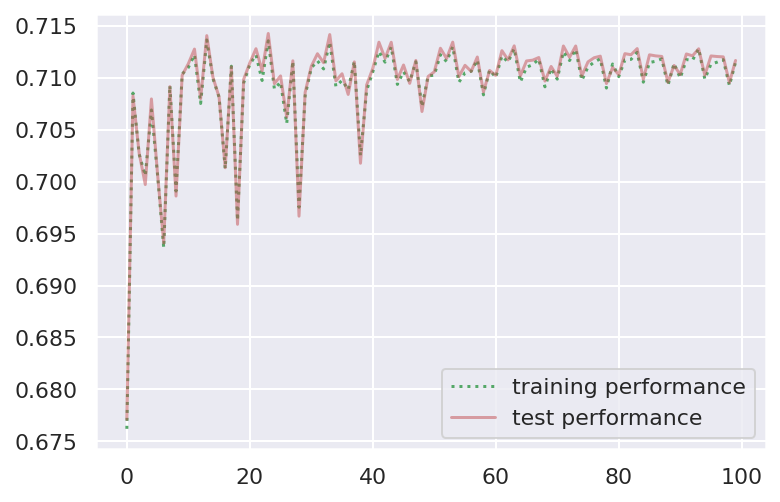

In [59]:
plt.plot(accuracy_train_list, "g:", label="training performance")
plt.plot(accuracy_test_list, "r-", alpha=0.5, label="test performance")
plt.legend()

나이브베이즈에서도 큰 데이터를 쓸 수 있다. <br>
나이브베이즈는 P(Y|X)를 구하는 과정이고, 이것을 구하기 위해 우리는 P(X|Y)P(Y)를 구한다. 

## 나이브베이즈 모형

똑같이, `warm_start`, `partial_fit`을 사용하면서 업데이트 하게 된다. <br>
이 `warm_start`가 중요한게, 이거를 True로 놓으면 다르다. 원래같으면, 각각의 model fit 할때마다, max_iter혹은 수렴하는 지점까지 끝까지 가는데, <br>
***`warm_start=True`로 해놓으면, 한번 들어오고 fit할때마다 딱 한번 업데이트 하게 된다.***<br>
기존에 max까지 가던 것을 쪼개서 간다고 생각하면 된다. 

![1_140.jpeg](./materials/1_140.jpeg)

나이브베이즈 모형과 같은 생성모형은 일부 데이터를 이용하여 구한 확률분포를 사전확률분포로 사용할 수 있다.

대표 수종 데이터 중 X11 부터는 0과 1로 이루어진 데이터이므로 베르누이 나이브 베이즈 모형을 사용할 수 있다. 

In [65]:
%%time

from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB().fit(X_train[:, 10:], y_train)

CPU times: user 457 ms, sys: 139 ms, total: 596 ms
Wall time: 441 ms


In [66]:
y_train_pred = model.predict(X_train[:, 10:])
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54    158952
           1       0.65      0.78      0.71    212284
           2       0.60      0.87      0.71     26988
           3       0.44      0.58      0.50      2049
           4       0.23      0.07      0.10      7108
           5       0.23      0.20      0.22     13013
           6       0.62      0.58      0.60     15365

    accuracy                           0.63    435759
   macro avg       0.49      0.51      0.48    435759
weighted avg       0.63      0.63      0.62    435759



In [67]:
y_test_pred = model.predict(X_test[:, 10:])
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54     52888
           1       0.65      0.78      0.71     71017
           2       0.59      0.86      0.70      8766
           3       0.45      0.59      0.51       698
           4       0.21      0.06      0.09      2385
           5       0.23      0.21      0.22      4354
           6       0.62      0.59      0.61      5145

    accuracy                           0.63    145253
   macro avg       0.49      0.51      0.48    145253
weighted avg       0.63      0.63      0.62    145253



feature 다 빼고, 11개째 정수로 된것만 사용하니깐 퍼포먼스 조금 떨어지는 것은 어쩔 수 없다. 

n=0 train accuracy=0.632 test accuracy=0.632
n=1 train accuracy=0.633 test accuracy=0.633
n=2 train accuracy=0.633 test accuracy=0.634
n=3 train accuracy=0.632 test accuracy=0.632
n=4 train accuracy=0.633 test accuracy=0.633
n=5 train accuracy=0.632 test accuracy=0.632
n=6 train accuracy=0.632 test accuracy=0.633
n=7 train accuracy=0.633 test accuracy=0.633
n=8 train accuracy=0.632 test accuracy=0.632
n=9 train accuracy=0.632 test accuracy=0.632
CPU times: user 14.5 s, sys: 1.45 s, total: 15.9 s
Wall time: 4.24 s


<function matplotlib.pyplot.show(close=None, block=None)>

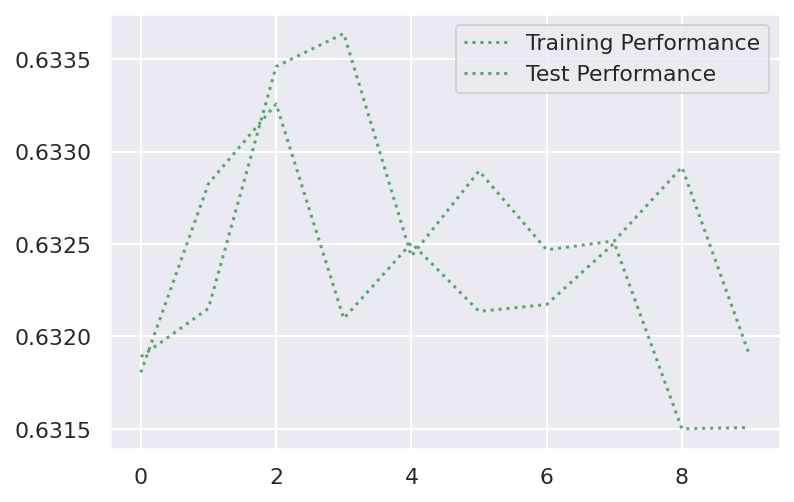

In [71]:
%%time

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = BernoulliNB(alpha=0.1)

n_split = 10
n_X = len(y_train) // n_split
accuracy_train_list=[]
accuracy_test_list=[]
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.partial_fit(X, y, classes=classes)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    accuracy_test = accuracy_score(y_test, model.predict(X_test)) 
    print("n={:d} train accuracy={:5.3f} test accuracy={:5.3f}".format(n, accuracy_train, accuracy_test))
    
    
plt.plot(accuracy_train_list, "g:", label="Training Performance")
plt.plot(accuracy_test_list, "g:", label="Test Performance")
plt.legend()
plt.show

## Random Forest

원래는 쪼개서 뭘 넣어서 할 순 없다. 그런데 약간 tricky하게, 기형적으로 할 수 있다. <br>

하단 코드 설명
![1_141.jpeg](./materials/1_141.jpeg)

In [72]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train, y_train)

CPU times: user 2min 21s, sys: 3.35 s, total: 2min 24s
Wall time: 2min 28s


In [74]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158952
           1       1.00      1.00      1.00    212284
           2       1.00      1.00      1.00     26988
           3       1.00      1.00      1.00      2049
           4       1.00      1.00      1.00      7108
           5       1.00      1.00      1.00     13013
           6       1.00      1.00      1.00     15365

    accuracy                           1.00    435759
   macro avg       1.00      1.00      1.00    435759
weighted avg       1.00      1.00      1.00    435759



In [75]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     52888
           1       0.95      0.97      0.96     71017
           2       0.94      0.96      0.95      8766
           3       0.92      0.88      0.90       698
           4       0.95      0.77      0.85      2385
           5       0.93      0.89      0.91      4354
           6       0.97      0.94      0.96      5145

    accuracy                           0.95    145253
   macro avg       0.95      0.91      0.92    145253
weighted avg       0.95      0.95      0.95    145253



랜덤 포레스트와 같은 앙상블 모형에서는 일부 데이터를 사용한 모형을 개별 분류기로 사용할 수 있다.

fit을 할때마다, n_estimators라는 속성을 조절해서 랜덤포레스트 안에 있는 트리를 늘릴 수가 있다. <br>


In [94]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_split = 10
n_X = len(y_train) // n_split
num_tree_ini = 10
num_tree_step = 10

# warm_start라고 되어 있으면 두번째 fit할때 첫번째 생성 한거는 안건든다. 
model = RandomForestClassifier(n_estimators=num_tree_ini, warm_start=True)

accuracy_train_list=[]
accuracy_test_list=[]

for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.fit(X, y)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_train_list.append(accuracy_train)
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    accuracy_test_list.append(accuracy_test)
    print("epoch={:d} train accuracy={:5.3f} test accuracy={:5.3f}".format(n, accuracy_train, accuracy_test))
    
    model.n_estimators += num_tree_step

epoch=0 train accuracy=0.866 test accuracy=0.851
epoch=1 train accuracy=0.891 test accuracy=0.874
epoch=2 train accuracy=0.898 test accuracy=0.879
epoch=3 train accuracy=0.902 test accuracy=0.882
epoch=4 train accuracy=0.904 test accuracy=0.885
epoch=5 train accuracy=0.905 test accuracy=0.886
epoch=6 train accuracy=0.906 test accuracy=0.887
epoch=7 train accuracy=0.907 test accuracy=0.887
epoch=8 train accuracy=0.907 test accuracy=0.888
epoch=9 train accuracy=0.908 test accuracy=0.889
CPU times: user 1min 27s, sys: 4.16 s, total: 1min 31s
Wall time: 1min 35s


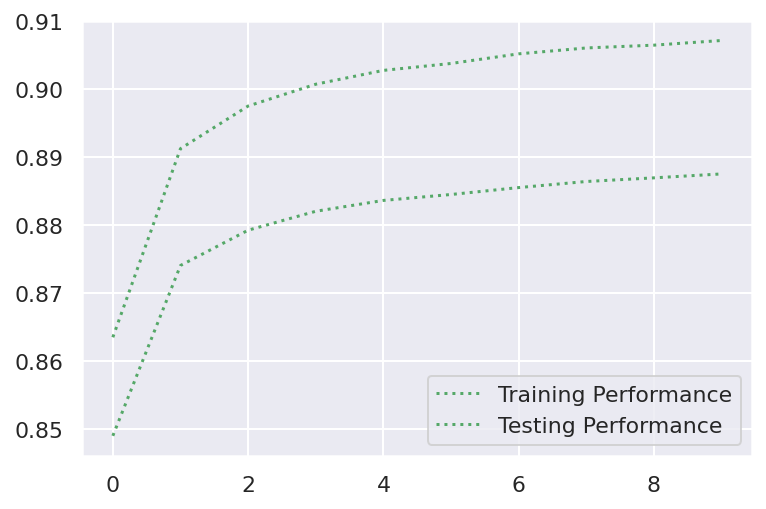

In [77]:
plt.plot(accuracy_train_list, "g:", label="Training Performance")
plt.plot(accuracy_test_list, "g:", label="Testing Performance")
plt.legend()
plt.show()

원래는 성능 이것보다 좋은데, 성능이 엄청 올라가지는 않네<br>
정확하게는 원래 문제를 푼것은 아니라서 그래. 약간 tricky한 방법.

위에 랜덤포레스트에 썻던 방식은 Gradient Boosting이나, ADA Boosting에도 똑같이 사용할 수 있다. <br>
앞에 모델 10개는 첫번째 데이터, 뒤에 10개는 두번째 데이터 이런식으로 해갈 수 있다. <br>
완벽히 똑같은 문제를 푼건 아니여도, 어느정도 비슷한 성능은 나온다는 것. 

## 그레디언트 부스팅

그레디언트 부스팅에서는 초기 커미티 멤버로 일부 데이터를 사용하여 학습한 모형을 사용할 수 있다.

In [103]:
%%time

from lightgbm import train, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

params = {
    'objective': 'multiclass',
    "num_class": len(classes),
    'learning_rate': 0.2,
    'seed': 0,
}

n_split = 10
n_X = len(y_train) // n_split
num_tree = 10
model = None
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model = train(params, init_model=model, train_set=Dataset(X, y),
                  keep_training_booster=True, num_boost_round=num_tree)
    print(model.predict(X_test))
    accuracy_train = accuracy_score(y_train, np.argmax(model.predict(X_train), axis=1))
    accuracy_test = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1)) 
    print("n={:d} train accuracy={:5.3f} test accuracy={:5.3f}".format(n, accuracy_train, accuracy_test))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 43575, number of used features: 50
[LightGBM] [Info] Start training from score -0.991573
[LightGBM] [Info] Start training from score -0.729247
[LightGBM] [Info] Start training from score -2.791656
[LightGBM] [Info] Start training from score -5.302342
[LightGBM] [Info] Start training from score -4.096067
[LightGBM] [Info] Start training from score -3.552941
[LightGBM] [Info] Start training from score -3.347910
[[0.09620881 0.80641407 0.03022172 ... 0.03599328 0.02513851 0.0053073 ]
 [0.07936226 0.9037865  0.00533768 ... 0.00522988 0.00257364 0.00326886]
 [0.09816922 0.83866163 0.01984846 ... 0.0337048  0.0039408  0.00499954]
 ...
 [0.03524808 0.20061921 0.06180452 ... 0.32577564 0.37267245 0.00345946]
 [0.89140228 0.09629113 0.0049875

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[[1.36734057e-02 9.79287092e-01 4.43987436e-03 ... 9.18990001e-13
  2.59962793e-03 0.00000000e+00]
 [7.45486680e-33 1.49649879e-31 1.00000000e+00 ... 6.11323673e-38
  0.00000000e+00 0.00000000e+00]
 [1.23008106e-02 9.80657042e-01 9.90092175e-08 ... 7.04204867e-03
  0.00000000e+00 0.00000000e+00]
 ...
 [7.94193275e-03 1.81485646e-01 4.05787545e-02 ... 2.62195650e-03
  7.67371711e-01 0.00000000e+00]
 [9.54424405e-01 4.55755949e-02 0.00000000e+00 ... 2.52031077e-27
  0.00000000e+00 0.00000000e+00]
 [9.64317848e-01 3.36522965e-02 1.21289744e-41 ... 0.00000000e+00
  0.00000000e+00 2.02985559e-03]]
n=7 train accuracy=0.788 test accuracy=0.783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

In [96]:
accuracy_train, accuracy_test

(0.8014957809247772, 0.795529180120204)

In [97]:
import lightgbm

model_lgbm = lightgbm.LGBMClassifier(n_estimators=100, max_depth=1, random_state=0)

In [98]:
%%time
boost_model = model_lgbm.fit(X_train, y_train)

CPU times: user 25.2 s, sys: 777 ms, total: 26 s
Wall time: 4.15 s


In [99]:
print(accuracy_score(y_train, boost_model.predict(X_train)))

0.715826867603423


In [100]:
print(accuracy_score(y_test, boost_model.predict(X_test)))

0.7141883472286287
